<a href="https://www.kaggle.com/code/zahrasyifaul/apple-vs-orange-classification-with-resnet18?scriptVersionId=244460525" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# APPLE N ORANGE CLASSIFICATION WITH RESNET18

# IMPORT LIBRARY

In [14]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# SETUP DAN TRANSFORMASI DATA

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/input/fruitdataset/archive/fruit-dataset"
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Using device: cuda


# LOAD DATASET DAN SPLIT

In [16]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_percent = 0.2
val_size = int(len(full_dataset) * val_percent)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = full_dataset.classes
print("Class names:", 'apple ,','orange')

Class names: apple , orange


# VISUALISASI SAMPEL GAMBAR

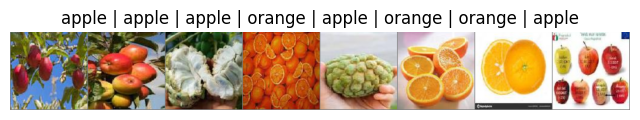

In [17]:
def imshow(img, title):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:8]), title=' | '.join([class_names[i] for i in labels[:8]]))

# LOAD MODEL RESNET18

In [18]:
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# TRAINING DAN EVALUASI

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.001)
train_losses = []

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)  # Tambahkan ini
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).round().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Accuracy: {acc*100:.2f}%")
    print(f"Confusion Matrix - Epoch [{epoch+1}/{num_epochs}]")
    # for row in cm:
    #     print(' '.join(f"{val:4d}" for val in row))


    # plt.figure(figsize=(4, 4))
    # sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel("prediksi")
    # plt.ylabel("benar")
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()


Epoch [1/50], Loss: 0.6231
Validation Accuracy: 74.38%
Confusion Matrix - Epoch [1/50]

Epoch [2/50], Loss: 0.4749
Validation Accuracy: 89.38%
Confusion Matrix - Epoch [2/50]

Epoch [3/50], Loss: 0.3996
Validation Accuracy: 87.50%
Confusion Matrix - Epoch [3/50]

Epoch [4/50], Loss: 0.3333
Validation Accuracy: 91.25%
Confusion Matrix - Epoch [4/50]

Epoch [5/50], Loss: 0.2967
Validation Accuracy: 93.75%
Confusion Matrix - Epoch [5/50]

Epoch [6/50], Loss: 0.2721
Validation Accuracy: 92.50%
Confusion Matrix - Epoch [6/50]

Epoch [7/50], Loss: 0.2677
Validation Accuracy: 95.62%
Confusion Matrix - Epoch [7/50]

Epoch [8/50], Loss: 0.2196
Validation Accuracy: 95.62%
Confusion Matrix - Epoch [8/50]

Epoch [9/50], Loss: 0.2402
Validation Accuracy: 94.38%
Confusion Matrix - Epoch [9/50]

Epoch [10/50], Loss: 0.2201
Validation Accuracy: 95.00%
Confusion Matrix - Epoch [10/50]

Epoch [11/50], Loss: 0.0998
Validation Accuracy: 94.38%
Confusion Matrix - Epoch [11/50]

Epoch [12/50], Loss: 0.2210

# VISUALISASI LOSS KONVERGEN

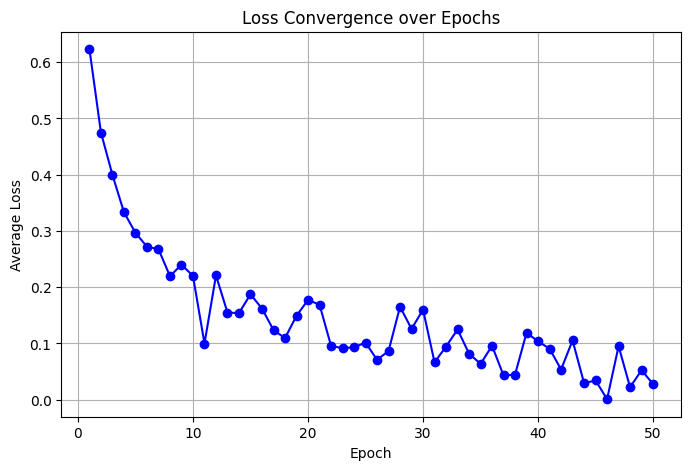

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue')
plt.title("Loss Convergence over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# PENGUJIAN GAMBAR 

Predicted: orange (Confidence: 100.00%)


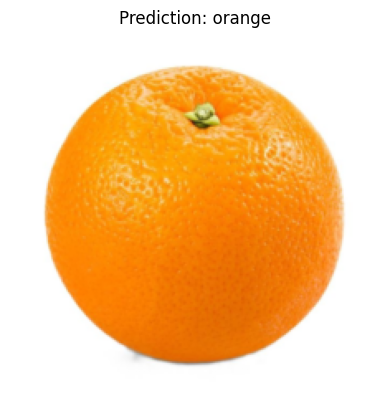

In [21]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Apply same transform as test set
    image = transform(image).unsqueeze(0).to(device)

    # Set model to eval
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output).item()
        label = 1 if pred > 0.5 else 0
        confidence = pred if label == 1 else 1 - pred

    print(f"Predicted: {class_names[label]} (Confidence: {confidence*100:.2f}%)")

    # Show the image
    img_show = image.squeeze().cpu() * 0.5 + 0.5  # unnormalize
    npimg = img_show.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Prediction: {class_names[label]}")
    plt.axis('off')
    plt.show()

# Contoh penggunaan:
# ganti '/kaggle/input/sampel/apple.jpg' dengan path gambar kamu
test_image_path = "/kaggle/input/fruitdataset/archive/fruit-dataset/train/jeruk.jpg"
predict_image(test_image_path, model, test_transform, class_names)
